# Analyse des dommages et des tirs en Isère
Auteur : Daniel Thonon

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Apply the default theme
sns.set_theme()

In [15]:
# data_url = "https://raw.githubusercontent.com/dthonon/pna_loup_suivi/main/data/"
data_url = "../data/"
# Lecture des départements
constats = pd.read_csv(
    data_url + "bilan_constat_loup_38.csv",
    sep=",",
    header=0,
    names=[
        "Commune",
        "Cercle",
        "Secteur",
        "Lieu-dit",
        "Date attaque",
        "Num semaine",
        "Animaux concernés",
        "Victimes constatées",
        "Taille troupeau ou lot",
        "Conclusion expertise",
        "Indemnisation",
        "Protocole",
        "Num AP tir",
        "Année",
    ],
    usecols=[
        "Commune",
        "Cercle",
        "Secteur",
        "Lieu-dit",
        "Date attaque",
        "Animaux concernés",
        "Victimes constatées",
        "Taille troupeau ou lot",
        "Conclusion expertise",
        "Indemnisation",
        "Année",
    ]
)
constats

,Commune,Cercle,Secteur,Lieu-dit,Date attaque,Animaux concernés,Victimes constatées,Taille troupeau ou lot,Conclusion expertise,Indemnisation,Année
0,VATILIEU,2,Bas Grésivaudan,Charbonnière,14/04/17,Ovin,8,40,Loup,Oui,2017
1,VATILIEU,2,Bas Grésivaudan,Charbonnière,16/04/17,Ovin,7,40,Loup,Oui,2017
2,VATILIEU,2,Bas Grésivaudan,Charbonnière,17/04/17,Ovin,2,40,Loup,Oui,2017
3,VATILIEU,2,Bas Grésivaudan,Charbonnière,04/05/17,Ovin,3,40,Loup,Oui,2017
4,VATILIEU,1,Bas Grésivaudan,Charbonnière,17/05/17,Ovin,1,5,Loup,Oui,2017
...,...,...,...,...,...,...,...,...,...,...,...
1969,COGNIN-LES-GORGES,1,Vercors Nord,NaN,28/07/22,Ovin,1,261,Loup non exclu,Oui,2022
1970,MALLEVAL-EN-VERCORS,1,Vercors Nord,Bourg,01/06/22,Veau,1,18,Loup non exclu,Oui,2022
1971,MALLEVAL-EN-VERCORS,1,Vercors Nord,le Village,23/05/22,Veau,1,19,Loup typé,Oui,2022
1972,SAINT-QUENTIN-SUR-ISÈRE,1,Vercors Nord,Village,16/05/22,Ovin,2,NaN,Loup non exclu,Non indemnisable,2022


## Evolution des statuts d'indemnisation

In [3]:
pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Indemnisation",
    columns="Année",
    aggfunc=np.sum,
    fill_value=0,
    margins=True,
    margins_name="Total",
)


Année,2017,2018,2019,2020,2021,2022,Total
Indemnisation,,,,,,,
Attente transmission constat,0,0,0,0,3,4,7
En cours d'instruction,53,0,72,1,0,0,126
Non - loup exclu,17,23,34,16,18,12,120
Non indemnisable,6,31,7,56,49,85,234
Oui,639,700,1055,1190,963,1005,5552
Total,715,754,1168,1263,1033,1106,6039


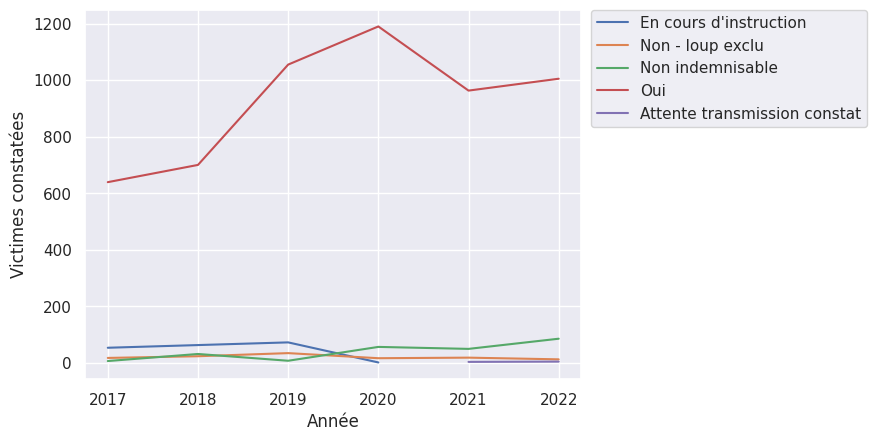

In [4]:
par_indemnisation_l = constats.groupby(["Année", "Indemnisation"]).sum(numeric_only=True)
sns.lineplot(data=par_indemnisation_l, x="Année", y="Victimes constatées", hue="Indemnisation");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

Année,2022
Indemnisation,
Attente transmission constat,4
En cours d'instruction,0
Non - loup exclu,12
Non indemnisable,85
Oui,1005


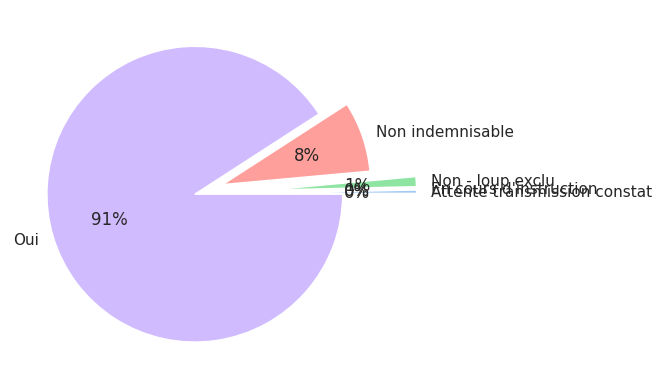

In [10]:
par_indemnisation = pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Indemnisation",
    columns="Année",
    aggfunc=np.sum,
    fill_value=0,
)
data = list(par_indemnisation[[2022]].values.flat)
labels = par_indemnisation[[2022]].index.values
colors = sns.color_palette("pastel")[0:7]
explode = (0.5, 0.5, 0.5, 0.2, 0)
plt.pie(data, labels=labels, colors=colors, explode=explode, autopct="%1.0f%%", labeldistance=1.1)
par_indemnisation[[2022]]


In [16]:
constats_o = constats.query("Indemnisation == 'Oui'")

## Evolution par type d'animal de rente prédaté

In [19]:
par_animal = pd.pivot_table(
    constats_o,
    values="Victimes constatées",
    index="Animaux concernés",
    columns="Année",
    aggfunc=np.sum,
    fill_value=0,
    # margins=True,
    # margins_name="Total"
)
par_animal

Année,2017,2018,2019,2020,2021,2022
Animaux concernés,,,,,,
Anon naissant,1,0,0,0,0,0
Autre,0,0,0,3,0,2
Bovin,4,17,17,28,13,26
Canin,0,1,0,4,2,3
Caprin,4,4,14,33,46,40
Equin,0,2,3,0,1,2
Ovin,622,667,1001,1107,854,888
Veau,4,0,11,8,33,29
Veau naissant,4,9,9,7,14,15


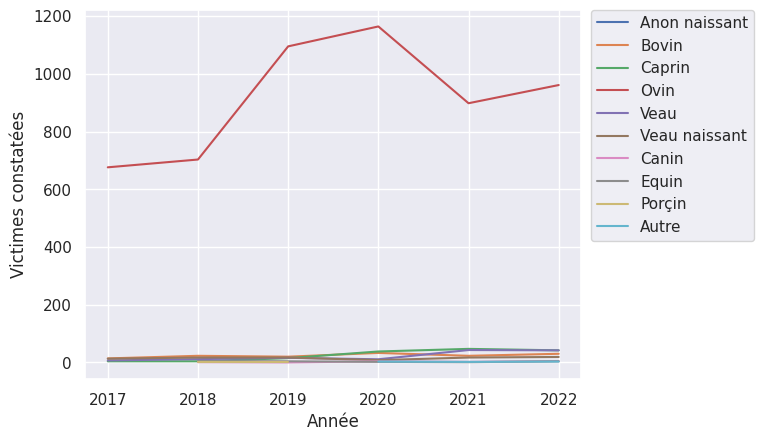

In [20]:
par_animal_l = constats.groupby(["Année", "Animaux concernés"]).sum(numeric_only=True)
sns.lineplot(data=par_animal_l, x="Année", y="Victimes constatées", hue="Animaux concernés");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);


## Evolution par secteur

In [7]:
par_secteur = pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Secteur",
    columns="Année",
    aggfunc=np.sum,
    fill_value=0,
    margins=True,
    margins_name="Total"
)
par_secteur

Année,2017,2018,2019,2020,2021,2022,Total
Secteur,,,,,,,
Bas Drac,9,0,0,9,0,2,20
Bas Grésivaudan,21,1,5,43,3,17,90
Beaumont,5,16,18,35,3,29,106
Belledonne Centre,53,22,38,51,46,45,255
Belledonne Nord,20,41,18,20,15,23,137
Belledonne Sud,32,17,25,18,39,99,230
Bièvre,1,0,1,4,8,9,23
Chambarans,0,5,0,0,4,57,66
Chartreuse,0,20,12,23,8,20,83


## Evolution par commune

In [8]:
par_commune = pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Commune",
    columns="Année",
    aggfunc=np.sum,
    fill_value=0,
    margins=True,
    margins_name="Total"
)
pd.set_option('display.max_rows', 500)
par_commune

Année,2017,2018,2019,2020,2021,2022,Total
Commune,,,,,,,
ALLEMOND,20,3,1,12,5,4,45
ALLEVARD,18,21,6,2,1,0,48
AURIS,10,0,4,49,4,5,72
AUTRANS-MÉAUDRE EN VERCORS,2,0,0,0,4,0,6
AVIGNONET,6,0,0,0,0,1,7
BESSE,26,2,22,13,31,19,113
BESSINS,0,0,0,0,0,4,4
BIOL,0,0,0,0,3,0,3
BOSSIEU,0,0,0,0,10,11,21
